In [1]:
# in our previous model, we only took 1 character of context (bigram) so we got not so good results
# if we take 2 characters as context , we will grow into 27 * 27 context matrix 
# if we take 3 characters as context , we will grow into 27 * 27 * 27 context matrix 
# it will be extremely difficult to keep track of these counts
# we are following https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf

In [2]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [3]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [4]:
# build the vocabulary of characters and mappings to/from integers
chars = sorted(list(set(''.join(words))))
print(chars, '\n')
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
print(stoi , '\n')
itos = {i:s for s,i in stoi.items()}
print(itos , '\n')

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z'] 

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0} 

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'} 



In [5]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:1]:
    print(w)
    context = [0] * block_size # the number of characters we are looking at
    for ch in w + '.': # add the end char '.' to word
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X)
print(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
tensor([[ 0,  0,  0],
        [ 0,  0,  5],
        [ 0,  5, 13],
        [ 5, 13, 13],
        [13, 13,  1]])
tensor([ 5, 13, 13,  1,  0])


In [6]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []
for w in words[:5]:
    context = [0] * block_size # the number of characters we are looking at
    for ch in w + '.': # add the end char '.' to word
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        #print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)
print(X.shape)
print(Y.shape)

# from 5 words, we created 32 examples. each input is 3 integers. and we have 32 labels for each input

torch.Size([32, 3])
torch.Size([32])


In [7]:
# embedding lookup table of lower dimension. In original paper, the authors cram 17000 words into 30 dimension space.
# we are working at char level, so we have 27 characters (26 + '.'). let's cram them into 2 dim space
C = torch.randn((27,2))

In [8]:
print(X.shape, C.shape)

torch.Size([32, 3]) torch.Size([27, 2])


In [9]:
C[X].shape # we get the embedding vector for every [32,3] input. power of pytorch indexing.
# how does this work ? suppose we take an input X[1]. That's a tensor [0,0,5]. when we pass it to C, we are basically
# asking C to give us the data it has at index 0 , index 0 and index 5
# so it gives us a 3,2 output 

torch.Size([32, 3, 2])

In [10]:
X[1]

tensor([0, 0, 5])

In [11]:
C[X[1]]

tensor([[-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [-0.0515, -0.2759]])

In [12]:
#so the embedding is 
emb = C[X]
emb.shape

torch.Size([32, 3, 2])

In [13]:
# let's create the hidden layer
# our input is 3 dimension , and each has embedding in two dimension
# so this layer will have 6 dimensions input
W1 = torch.randn((6,100)) # 100 is the arbitrary number of neurons we want to have 
b1 = torch.randn(100)

In [14]:
# emb @ W1 wont work because the dims dont match
# what we want to do is retrive the 3 parts of the emb (3,2) [3 represents the one hot enc of char and 2
# represents the dimension of embedding] and concatenate them

print(emb[: , 0 , :]) # embs of char 1
print(emb[: , 1 , :]) # embs of char 2
print(emb[: , 2 , :]) # emb of char 3


tensor([[-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [-0.0515, -0.2759],
        [ 1.0071, -0.7074],
        [-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [ 0.7338, -0.7256],
        [-0.5880, -0.2260],
        [ 0.8748, -0.3433],
        [-1.5788,  1.3383],
        [-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [ 0.5097, -0.6473],
        [-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [ 0.8748, -0.3433],
        [-1.5919, -1.4285],
        [ 0.5097, -0.6473],
        [-0.0986, -0.8607],
        [-0.0515, -0.2759],
        [-0.5880, -0.2260],
        [-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [-1.5919, -1.4285],
        [ 0.7338, -0.7256],
        [ 1.2747,  1.0312],
        [-0.7802, -1.5185]])
tensor([[-1.3275,  1.9425],
        [-1.3275,  1.9425],
        [-0.0515, -0.2759],
        [ 1.0071, -

In [15]:
# then we want to concatenate them  to create a layer of all embeddings for those 3 characters
torch.cat([emb[: , 0 , :] , emb[: , 1 , :] , emb[: , 2 , :]] , 1)
# BASICALLY IF THE FIRST INPUT IS ... -> ONE HOT ENCODING IS --> [0 ,0 ,0] --> EMBED FOR '.' IS [0.5291, -1.1664] 
# SO WE HAVE  [0.5291, -1.1664 , 0.5291, -1.1664 , 0.5291, -1.1664 ]  

tensor([[-1.3275,  1.9425, -1.3275,  1.9425, -1.3275,  1.9425],
        [-1.3275,  1.9425, -1.3275,  1.9425, -0.0515, -0.2759],
        [-1.3275,  1.9425, -0.0515, -0.2759,  1.0071, -0.7074],
        [-0.0515, -0.2759,  1.0071, -0.7074,  1.0071, -0.7074],
        [ 1.0071, -0.7074,  1.0071, -0.7074,  0.5097, -0.6473],
        [-1.3275,  1.9425, -1.3275,  1.9425, -1.3275,  1.9425],
        [-1.3275,  1.9425, -1.3275,  1.9425,  0.7338, -0.7256],
        [-1.3275,  1.9425,  0.7338, -0.7256, -0.5880, -0.2260],
        [ 0.7338, -0.7256, -0.5880, -0.2260,  0.8748, -0.3433],
        [-0.5880, -0.2260,  0.8748, -0.3433, -1.5788,  1.3383],
        [ 0.8748, -0.3433, -1.5788,  1.3383,  0.8748, -0.3433],
        [-1.5788,  1.3383,  0.8748, -0.3433,  0.5097, -0.6473],
        [-1.3275,  1.9425, -1.3275,  1.9425, -1.3275,  1.9425],
        [-1.3275,  1.9425, -1.3275,  1.9425,  0.5097, -0.6473],
        [-1.3275,  1.9425,  0.5097, -0.6473, -1.5788,  1.3383],
        [ 0.5097, -0.6473, -1.5788,  1.3

In [16]:
# we can use unbind to do this
print(emb.shape)
torch.unbind(emb, 1) # Returns a tuple of all slices along a given dimension, already without it
torch.cat(torch.unbind(emb, 1),1).shape

torch.Size([32, 3, 2])


torch.Size([32, 6])

In [17]:
# even better way
emb.view(32,6)

tensor([[-1.3275,  1.9425, -1.3275,  1.9425, -1.3275,  1.9425],
        [-1.3275,  1.9425, -1.3275,  1.9425, -0.0515, -0.2759],
        [-1.3275,  1.9425, -0.0515, -0.2759,  1.0071, -0.7074],
        [-0.0515, -0.2759,  1.0071, -0.7074,  1.0071, -0.7074],
        [ 1.0071, -0.7074,  1.0071, -0.7074,  0.5097, -0.6473],
        [-1.3275,  1.9425, -1.3275,  1.9425, -1.3275,  1.9425],
        [-1.3275,  1.9425, -1.3275,  1.9425,  0.7338, -0.7256],
        [-1.3275,  1.9425,  0.7338, -0.7256, -0.5880, -0.2260],
        [ 0.7338, -0.7256, -0.5880, -0.2260,  0.8748, -0.3433],
        [-0.5880, -0.2260,  0.8748, -0.3433, -1.5788,  1.3383],
        [ 0.8748, -0.3433, -1.5788,  1.3383,  0.8748, -0.3433],
        [-1.5788,  1.3383,  0.8748, -0.3433,  0.5097, -0.6473],
        [-1.3275,  1.9425, -1.3275,  1.9425, -1.3275,  1.9425],
        [-1.3275,  1.9425, -1.3275,  1.9425,  0.5097, -0.6473],
        [-1.3275,  1.9425,  0.5097, -0.6473, -1.5788,  1.3383],
        [ 0.5097, -0.6473, -1.5788,  1.3

In [18]:
# now the matrix mul works
h = emb.view((emb.shape[0],6)) @ W1 + b1 # we dont want to hardcode 32

In [19]:
# adding the non linearity
h = torch.tanh(h)

In [20]:
# final layer
W2 = torch.randn((100,27)) # now we need 27 outputs -> one for each char
b2 = torch.randn(27)

In [21]:
# logits
logits = h @ W2 + b2
logits.shape

torch.Size([32, 27])

In [22]:
counts = logits.exp()
prob = counts / counts.sum(1, keepdims =True)

In [23]:
prob.shape

torch.Size([32, 27])

In [24]:
prob[torch.arange(32) , Y] # get the prob of target from prob matrix

tensor([1.2107e-01, 4.2062e-07, 2.7437e-01, 1.8250e-08, 2.7490e-09, 2.4591e-04,
        5.1281e-11, 2.0385e-10, 2.2215e-05, 6.2011e-13, 5.6370e-08, 2.8434e-04,
        1.1824e-10, 2.0814e-04, 5.0267e-11, 4.1479e-02, 7.9145e-08, 3.1619e-12,
        3.2873e-18, 2.9147e-08, 6.6476e-01, 1.6828e-04, 1.0758e-05, 2.6288e-10,
        2.9897e-06, 7.2773e-10, 3.8646e-10, 1.1974e-08, 4.2854e-10, 6.3489e-01,
        3.1334e-07, 1.4438e-10])

In [25]:
neg_log_loss = -prob[torch.arange(32) , Y].log().mean()
print(neg_log_loss)

tensor(15.8819)


In [26]:
# can do the count, prob and loss in one single method in pytorch. we get the same loss
F.cross_entropy(logits, Y)

tensor(15.8819)

In [27]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
print(X.shape, Y.shape)
C = torch.randn((27, 2), generator=g) # embedding of 27 chars in 2D
W1 = torch.randn((6, 100), generator=g)
b1 = torch.randn(100, generator=g)
W2 = torch.randn((100, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print('Total number of parameters : ' , sum(p.nelement() for p in parameters))

torch.Size([32, 3]) torch.Size([32])
Total number of parameters :  3481


In [28]:
for p in parameters:
    p.requires_grad = True

In [29]:
for _ in range(10):
    #forward pass
    emb = C[X] # [32,3,2]
    h = emb.view(-1,6) @ W1 + b1
    h = torch.tanh(h)
    logits = h @ W2 + b2 # [32 , 27]
    loss = F.cross_entropy(logits , Y)
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update grad 
    for p in parameters:
        p.data += -0.1 * p.grad

17.76971435546875
13.656400680541992
11.298768997192383
9.452457427978516
7.984262466430664
6.891321182250977
6.100014686584473
5.452036380767822
4.898151874542236
4.414663791656494


In [30]:
# this was only for words , and our input for those 5 words became 32 , 3 (after one hot encoding)
# as we take the entire dataset , the input will be even bigger
# in practice , we like to optimize loss over batches of bata , not the entire data set
# randomly select a mini batch of data

torch.randint(0,5, (32,)) # give 32 ints between 0 and 5

torch.randint(0,X.shape[0], (32,)) # give 32 ints between 0 and number of inputs in X

tensor([22, 15, 11, 25, 26,  1, 14, 13, 31, 25, 22,  5,  4, 15, 24, 25, 24, 10,
        20, 16, 23, 14, 12, 24,  1, 29, 28,  8, 16, 10, 23, 29])

In [31]:
for _ in range(10):
    ix = torch.randint(0, X.shape[0], (32,)) # minibatch 
    #forward pass
    emb = C[X[ix]] # [32,3,2]
    h = emb.view(-1,6) @ W1 + b1
    h = torch.tanh(h)
    logits = h @ W2 + b2 # [32 , 27]
    loss = F.cross_entropy(logits , Y[ix])
    print(loss.item())
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update grad 
    for p in parameters:
        p.data += -0.1 * p.grad

4.061162948608398
2.5981428623199463
2.328188180923462
3.810340404510498
3.112499475479126
2.28739070892334
1.9184293746948242
2.216069221496582
3.096294641494751
1.6646702289581299


In [32]:
# in real life we will have the dataset be split into train , dev and test. now we will take the entire data

# build the dataset
block_size = 3 # context length: how many characters do we take to predict the next one?

def build_dataset(words):  
    X, Y = [], []
    for w in words:
        #print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
              #print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix] # crop and append

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [33]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g) # embedding of 27 chars in 10 dimensions insted of 2 dim
W1 = torch.randn((30, 200), generator=g) # 3 characters, each of 10 dim embedding, so 30 dim input ... 200 neurons
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]
print('Total number of parameters : ' , sum(p.nelement() for p in parameters))

Total number of parameters :  11897


In [34]:
for p in parameters:
    p.requires_grad = True

In [35]:
lossi = []
stepi = []

In [36]:
for i in range(200000):
  
  # minibatch construct
    ix = torch.randint(0, Xtr.shape[0], (32,))
  
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
  
    # update
    lr = 0.1 if i < 100000 else 0.01 # learning rate decay over time
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    stepi.append(i)
    #lossi.append(loss.log10().item())
    lossi.append(loss.item())

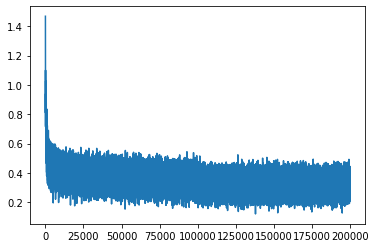

In [162]:
plt.plot(stepi, lossi)

In [37]:
lossi[-20:]

[1.7203383445739746,
 2.1895627975463867,
 1.9012714624404907,
 1.7211579084396362,
 1.8986085653305054,
 1.7795028686523438,
 1.7319889068603516,
 1.9536006450653076,
 2.318521738052368,
 2.463441848754883,
 2.3640260696411133,
 2.5725903511047363,
 2.09915828704834,
 2.2030224800109863,
 2.140836238861084,
 2.146395206451416,
 2.20281720161438,
 1.9810020923614502,
 1.955871820449829,
 1.8515732288360596]

In [163]:
# calculate loss on training
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100) 
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1351, grad_fn=<NllLossBackward0>)

In [164]:
# calculate validation loss
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h @ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1817, grad_fn=<NllLossBackward0>)

In [185]:
# sample from the model
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):
    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1,block_size,d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carmah.
amille.
khi.
mri.
rehiyah.
cassie.
mahith.
delynn.
jareei.
nellara.
chaiir.
kaleigh.
ham.
pori.
quinton.
lilea.
jamilio.
jermadiarisi.
fine.
pinsley.
